# Exploratory Data Analysis (EDA) & Preprocessing Pipeline for Elderly HAR Dataset

This notebook presents the exploratory data analysis (EDA) and preprocessing pipeline for a Human Activity Recognition (HAR) dataset collected using wearable inertial sensors. The dataset comprises data from multiple elderly subjects, each stored in individual CSV files, along with corresponding metadata detailing demographic and fall risk information.

The pipeline is structured as follows:

- **Dataset Structure Overview**: Exploration of the file and folder organization, including metadata and sensor signal structure.

- **Data Loading and Aggregation**: Automatic concatenation of all subject files into a unified DataFrame for global analysis.

- **Label Distribution**: Visualization and quantification of class balance to identify potential imbalances and rare activities.

- **Signal Inspection**: Plotting raw signals (accelerometer and gyroscope) for selected activities and subjects to visually assess patterns, noise, and transitions.

- **Filtering**: Application of a configurable Butterworth filter to reduce high-frequency noise and improve signal quality.

- **Normalization**: Min-max or z-score normalization applied based on statistics from the training set to standardize input features.

- **Train/Validation/Test Split**: Subject-based splitting strategy ensuring no data leakage between training and evaluation subsets.

This pipeline is designed to prepare the HAR data for robust and reproducible modeling with deep learning architectures, particularly for use cases involving elderly populations and real-world activity monitoring.

### Import Libraries
This cell imports necessary libraries for numerical computation, data manipulation, and visualization.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load Dataset
Here we load the raw inertial dataset into a pandas DataFrame from a CSV file.

In [3]:
import os
import pandas as pd

# === Define the root data folder ===
root_folder = 'D:\\PhD\\Ano_3\\Article_Dataset\\Dataset_Main_Folder\\Data'

# === Initialize list to collect DataFrames ===
all_data = []

# === Traverse subfolders (S01, S02, ..., S54) ===
for folder_name in sorted(os.listdir(root_folder)):
    folder_path = os.path.join(root_folder, folder_name)

    # Skip non-directory entries
    if not os.path.isdir(folder_path):
        continue

    # Expect only one CSV per folder
    for file in os.listdir(folder_path):
        if file.endswith('.csv'):
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path)

            # If 'Subject' column is missing, extract it from folder or file name
            if 'Subject' not in df.columns:
                subject_id = folder_name  # assumes folder is named S01, S02, etc.
                df['Subject'] = subject_id

            all_data.append(df)

# === Concatenate all DataFrames ===
full_df = pd.concat(all_data, ignore_index=True)

# === Preview and Save ===
print(f"✅ Total samples loaded: {full_df.shape[0]}")
print(full_df.head())

# Save to a CSV file if needed
# full_df.to_csv("concatenated_sensor_data.csv", index=False)


✅ Total samples loaded: 2623171
   Sample  Subject  Trial     ACC_X     ACC_Y     ACC_Z     GYR_X     GYR_Y  \
0       1       10      1 -0.268066  0.011941  0.976740 -0.482733  0.133168   
1       2       10      1 -0.268945  0.009082  0.975879 -0.329590  0.109863   
2       3       10      1 -0.265234  0.012988  0.971387 -0.451660 -0.549316   
3       4       10      1 -0.264648  0.014355  0.972168 -0.366211 -0.646973   
4       5       10      1 -0.259570  0.010449  0.971973 -0.415039 -0.244141   

      GYR_Z  LABEL  
0  0.316273      3  
1  0.048828      3  
2  0.061035      3  
3 -0.146484      3  
4  0.073242      3  


In [6]:
# === Set file paths ===
metadata_path = 'D:\\PhD\Ano_3\\Article_Dataset\\Dataset_Main_Folder\\Metadata\\Subjects_Info.csv'

# === Load sensor data ===
sensor_df = full_df #pd.read_csv(sensor_data_path)
print("✅ Sensor data loaded:")
print(sensor_df.head())
print(f"Shape: {sensor_df.shape}\n")

# === Load metadata ===
metadata_df = pd.read_csv(metadata_path)
print("✅ Metadata loaded:")
print(metadata_df.head())
print(f"Shape: {metadata_df.shape}\n")

# === Optional: Check for matching subjects ===
common_subjects = set(sensor_df['Subject']).intersection(metadata_df['Subject'])
print(f"🔍 Subjects present in both files: {len(common_subjects)} of {sensor_df['Subject'].nunique()} total in sensor data")

# === Optional: Merge metadata with sensor data ===
# This allows each sensor sample to carry its metadata for easy EDA or modeling
merged_df = pd.merge(sensor_df, metadata_df, on='Subject', how='left')
print("✅ Merged DataFrame sample:")
print(merged_df.head())


✅ Sensor data loaded:
   Sample  Subject  Trial     ACC_X     ACC_Y     ACC_Z     GYR_X     GYR_Y  \
0       1       10      1 -0.268066  0.011941  0.976740 -0.482733  0.133168   
1       2       10      1 -0.268945  0.009082  0.975879 -0.329590  0.109863   
2       3       10      1 -0.265234  0.012988  0.971387 -0.451660 -0.549316   
3       4       10      1 -0.264648  0.014355  0.972168 -0.366211 -0.646973   
4       5       10      1 -0.259570  0.010449  0.971973 -0.415039 -0.244141   

      GYR_Z  LABEL  
0  0.316273      3  
1  0.048828      3  
2  0.061035      3  
3 -0.146484      3  
4  0.073242      3  
Shape: (2623171, 10)

✅ Metadata loaded:
   Subject    Institution  Age Gender  Height  Weight Faller
0        1  CasaProfessor   84      F     155    43.1     NF
1        2  CasaProfessor   89      F     146    80.0     NF
2        3  CasaProfessor   90      F     150    63.0     NF
3        4  CasaProfessor   84      F     161    67.0     NF
4        5  CasaProfessor   85 

In [7]:
# Identify columns that are likely information data
information_columns = ['Sample', 'Age', 'Trial', 'Subject', 'Gender', 'Height', 'Weight', 'Faller', 'Institution']

# Create a DataFrame for information data
information_data = merged_df[information_columns]

# Create a DataFrame for sensor data (excluding the information columns)
sensor_data = merged_df.drop(columns=information_columns)

# Exploratory Data Analysis

### Explore Basic Statistics
This block generates summary statistics (mean, std, min, max) for each signal axis and Evaluates if there is any NaN value in the data

In [8]:
merged_df.isnull().sum() # check if you have any feature null

sensor_data.describe().transpose() # do general a statystical analysis of your data 


,count,mean,std,min,25%,50%,75%,max
ACC_X,2623171.0,-0.047852,0.282001,-7.219238,-0.176172,-0.049902,0.081543,14.900879
ACC_Y,2623171.0,-0.002212,0.155456,-5.247510,-0.052441,0.001758,0.059619,4.382568
ACC_Z,2623171.0,0.931778,0.217649,-5.221191,0.935254,0.984558,1.002002,6.893799
GYR_X,2623171.0,-0.396546,5.718937,-214.727783,-1.495361,-0.445557,0.695801,284.417725
GYR_Y,2623171.0,0.020492,12.327266,-1056.890869,-2.050781,-0.030518,2.197266,1173.278809
GYR_Z,2623171.0,0.194393,15.097919,-630.169678,-2.557373,0.067139,2.722168,1220.465088
LABEL,2623171.0,3.235662,2.512260,1.000000,2.000000,2.000000,4.000000,13.000000


### Distribution Analysis
Visualizes the number of samples per activity class to check for data imbalance.

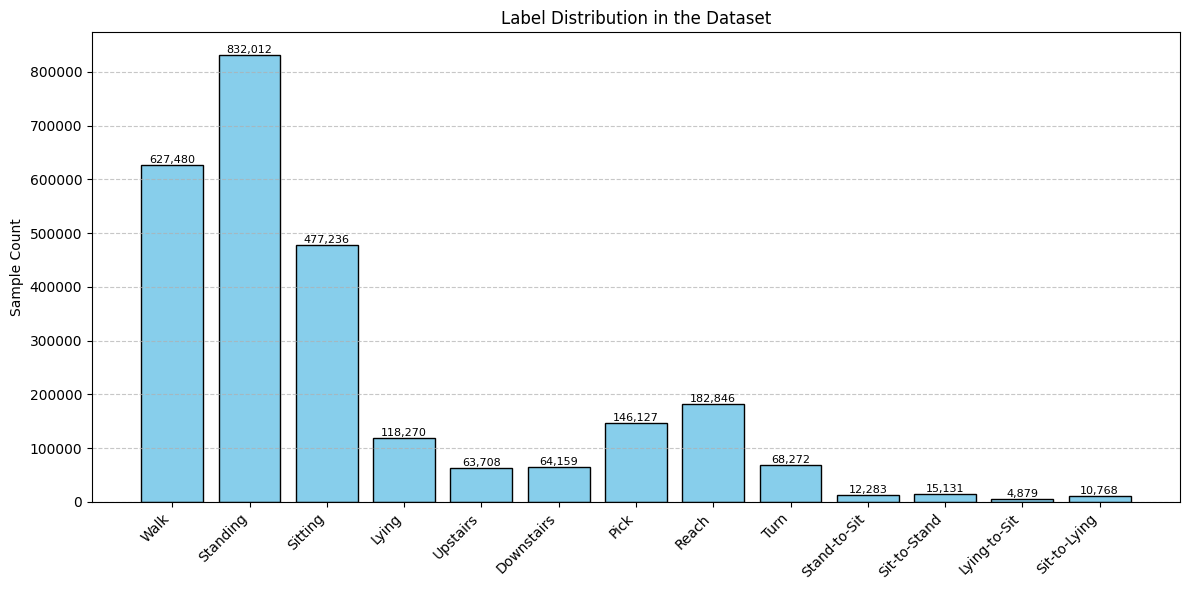

In [27]:
# === Define label ID to activity name mapping ===
label_map = {
    0: "Unknown",
    1: "Walk",
    2: "Standing",
    3: "Sitting",
    4: "Lying",
    5: "Upstairs",
    6: "Downstairs",
    7: "Pick",
    8: "Reach",
    9: "Turn",
    10: "Stand-to-Sit",
    11: "Sit-to-Stand",
    12: "Lying-to-Sit",
    13: "Sit-to-Lying"
}

# === Count samples per label ID ===
label_counts = merged_df['LABEL'].value_counts().sort_index()

# === Convert to lists for plotting ===
labels = [label_map[label] for label in label_counts.index]
counts = label_counts.values

# === Create bar plot ===
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, counts, color='skyblue', edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Sample Count')
plt.title('Label Distribution in the Dataset')
plt.tight_layout()

# === Display values on top of bars ===
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:,}', ha='center', va='bottom', fontsize=8)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Sensor Axis Distributions
Plots histograms of raw accelerometer and gyroscope signals to assess distribution and detect anomalies.

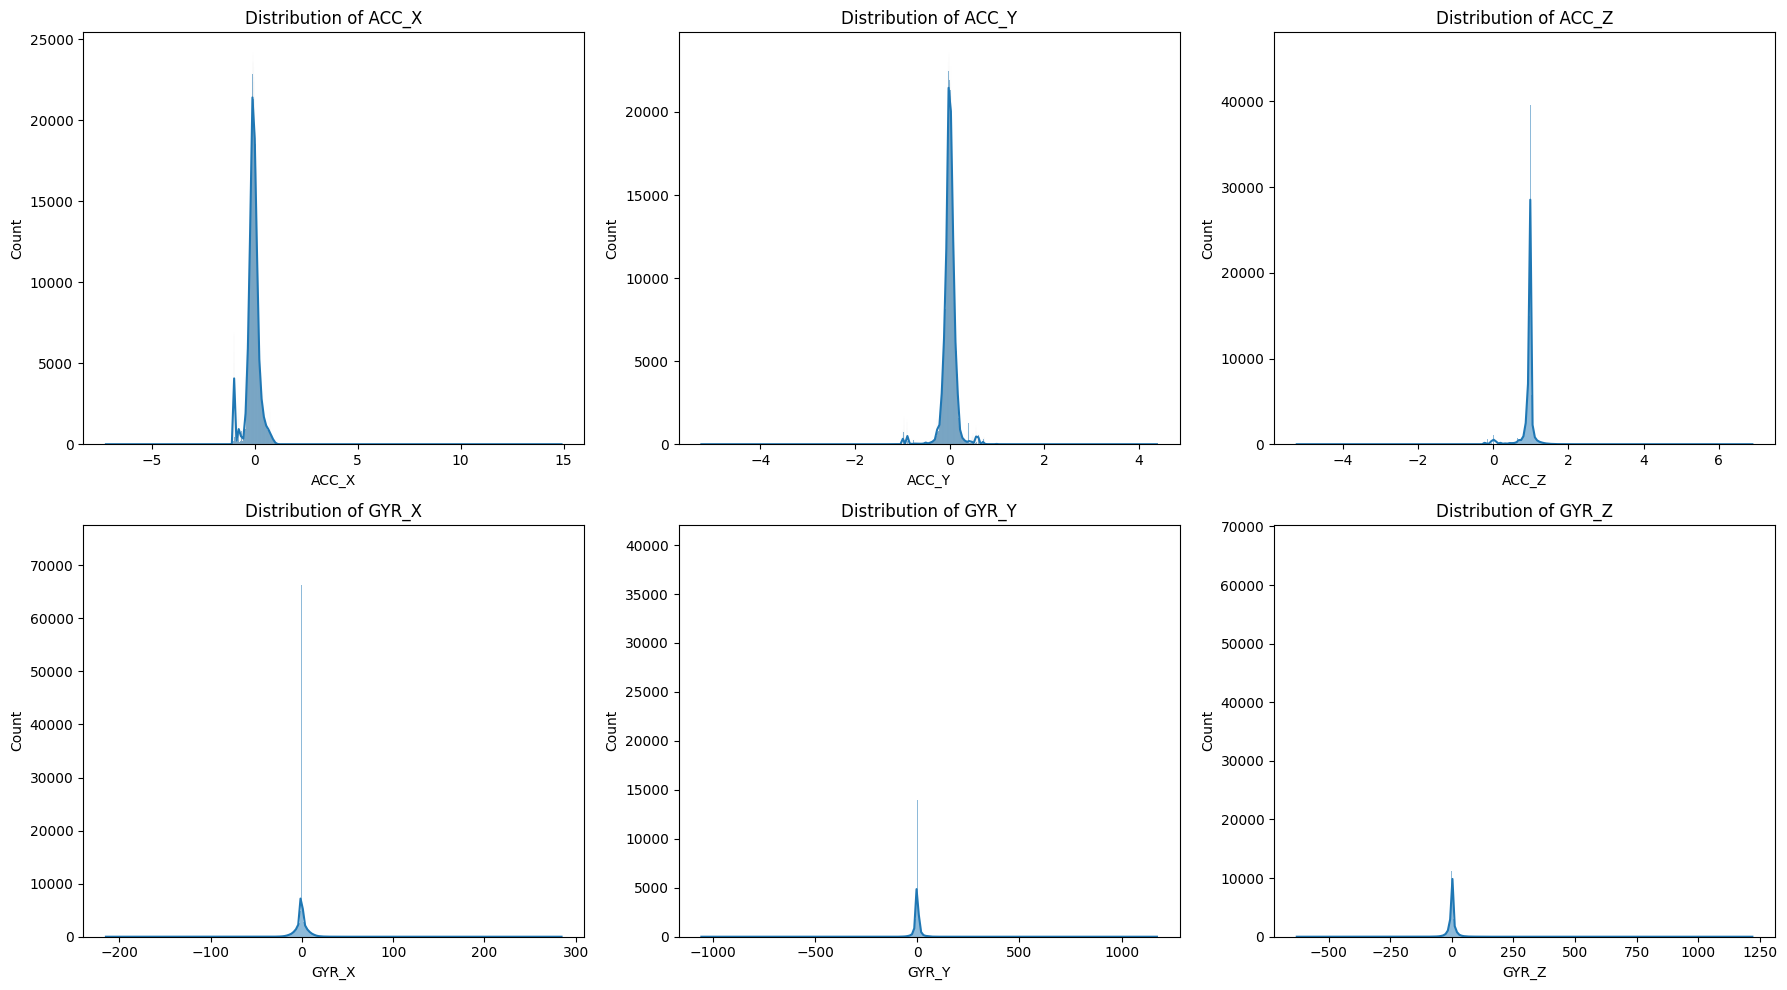

In [14]:
# Set up subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Loop through ACC and GYR columns to create subplots
for i, column in enumerate(['ACC_X', 'ACC_Y', 'ACC_Z', 'GYR_X', 'GYR_Y', 'GYR_Z']):
    sns.histplot(sensor_data[column], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {column}')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### Age Distribution Plot
Age Distribution Evaluation

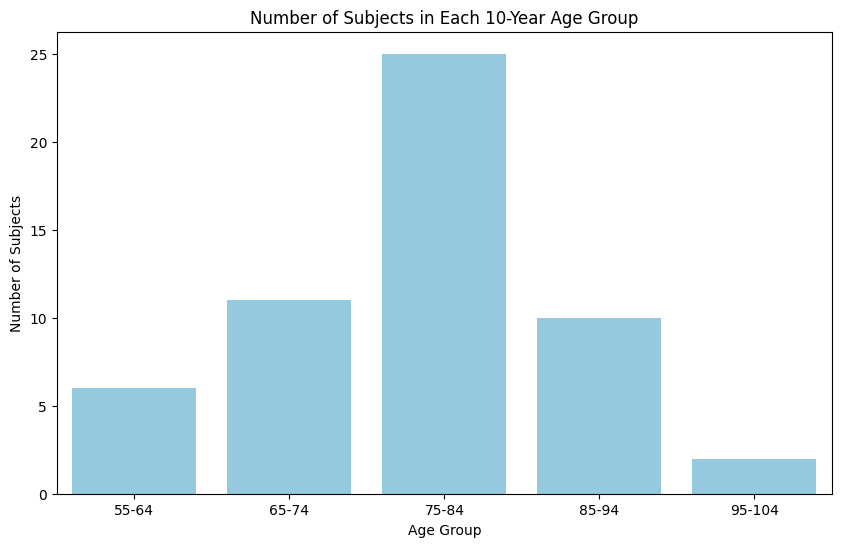

In [15]:
# Create age bins with 10-year gaps
bins = range(metadata_df['Age'].min(), metadata_df['Age'].max() + 11, 10)
labels = [f"{start}-{start + 9}" for start in bins[:-1]]
metadata_df['AgeGroup'] = pd.cut(metadata_df['Age'], bins=bins, labels=labels, right=False)

# Group by age group and count the number of unique subjects for each group
subject_counts = metadata_df.groupby('AgeGroup')['Subject'].nunique().reset_index()

# Create a bar plot for subject counts in each age group
plt.figure(figsize=(10, 6))
sns.barplot(x='AgeGroup', y='Subject', data=subject_counts, color='skyblue')

# Set labels and title
plt.xlabel('Age Group')
plt.ylabel('Number of Subjects')
plt.title('Number of Subjects in Each 10-Year Age Group')

# Show the plot
plt.show()

### Height Distribution Plot
Height Distribution Evaluation

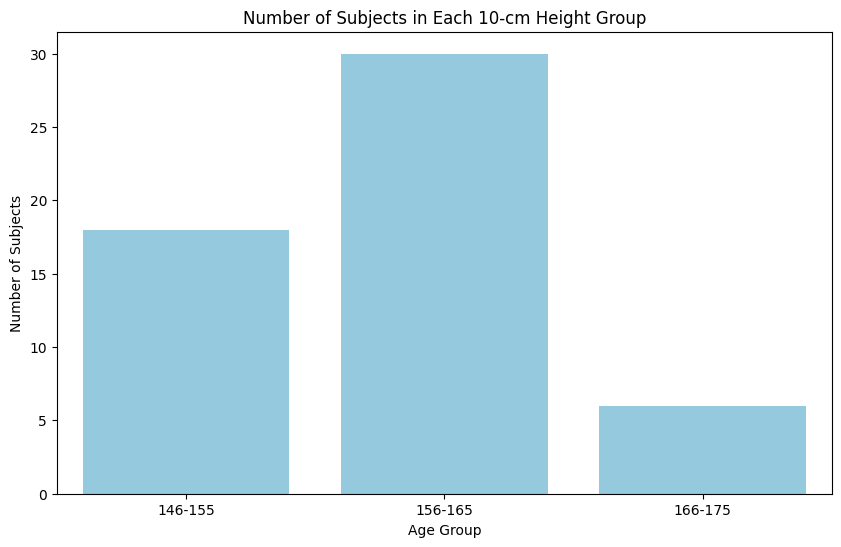

In [16]:
# Create age bins with 10-year gaps
bins = range(metadata_df['Height'].min(), metadata_df['Height'].max() + 11, 10)
labels = [f"{start}-{start + 9}" for start in bins[:-1]]
metadata_df['HeightGroup'] = pd.cut(metadata_df['Height'], bins=bins, labels=labels, right=False)

# Group by age group and count the number of unique subjects for each group
subject_counts = metadata_df.groupby('HeightGroup')['Subject'].nunique().reset_index()

# Create a bar plot for subject counts in each age group
plt.figure(figsize=(10, 6))
sns.barplot(x='HeightGroup', y='Subject', data=subject_counts, color='skyblue')

# Set labels and title
plt.xlabel('Age Group')
plt.ylabel('Number of Subjects')
plt.title('Number of Subjects in Each 10-cm Height Group')

# Show the plot
plt.show()

### Weight Distribution Plot
Weigth Distribution Evaluation

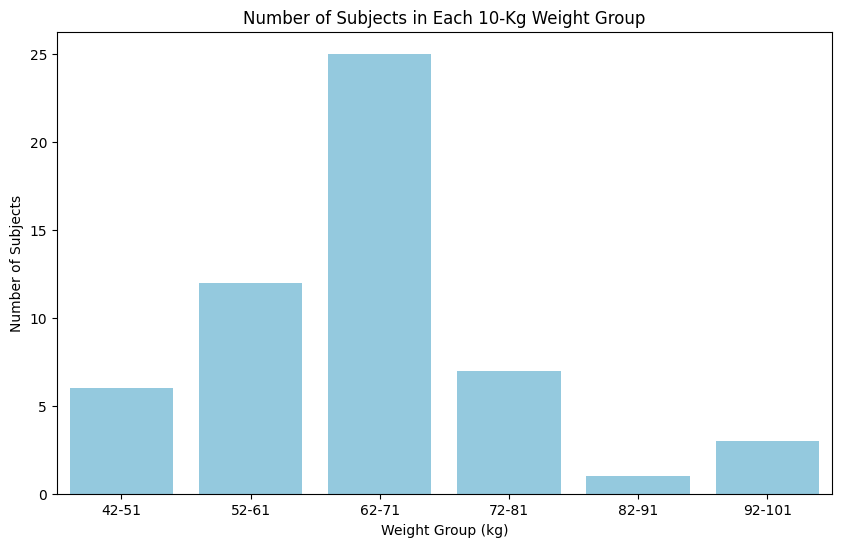

In [17]:
# Create weight bins with 10-kg gaps
bins = range(int(metadata_df['Weight'].min()), int(metadata_df['Weight'].max()) + 11, 10)
labels = [f"{start}-{start + 9}" for start in bins[:-1]]
metadata_df['WeightGroup'] = pd.cut(metadata_df['Weight'], bins=bins, labels=labels, right=False)

# Group by weight group and count the number of unique subjects for each group
subject_counts = metadata_df.groupby('WeightGroup')['Subject'].nunique().reset_index()

# Create a bar plot for subject counts in each weight group
plt.figure(figsize=(10, 6))
sns.barplot(x='WeightGroup', y='Subject', data=subject_counts, color='skyblue')

# Set labels and title
plt.xlabel('Weight Group (kg)')
plt.ylabel('Number of Subjects')
plt.title('Number of Subjects in Each 10-Kg Weight Group')

# Show the plot
plt.show()

### Gender Distribution Plot
Gender Distribution Evaluation

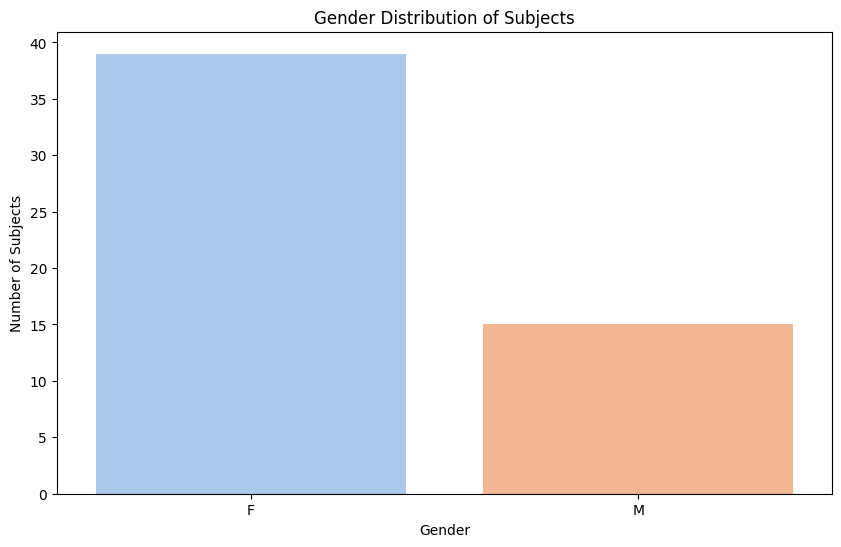

In [18]:
# Explicitly create bins for "Faller" label
faller_bins = [-0.5, 0.5, 1.5]  # 0: F, 1: M
faller_labels = ['F', 'M']
metadata_df['GenderGroup'] = pd.cut(metadata_df['Gender'].astype('category').cat.codes, bins=faller_bins, labels=faller_labels, right=False)

# Create a DataFrame with unique subjects and their corresponding gender
unique_subjects = metadata_df.drop_duplicates(subset='Subject')[['Subject', 'GenderGroup']]

# Count the number of subjects for each gender
gender_counts = unique_subjects['GenderGroup'].value_counts().reset_index()
gender_counts.columns = ['Gender', 'Number of Subjects']

# Create histogram
plt.figure(figsize=(10, 6))
sns.barplot(x='Gender', y='Number of Subjects', data=gender_counts, palette='pastel')

# Set labels and title
plt.xlabel('Gender')
plt.ylabel('Number of Subjects')
plt.title('Gender Distribution of Subjects')

# Show the plot
plt.show()

### Faller Status Distribution Plot
Faller Status Distribution Evaluation

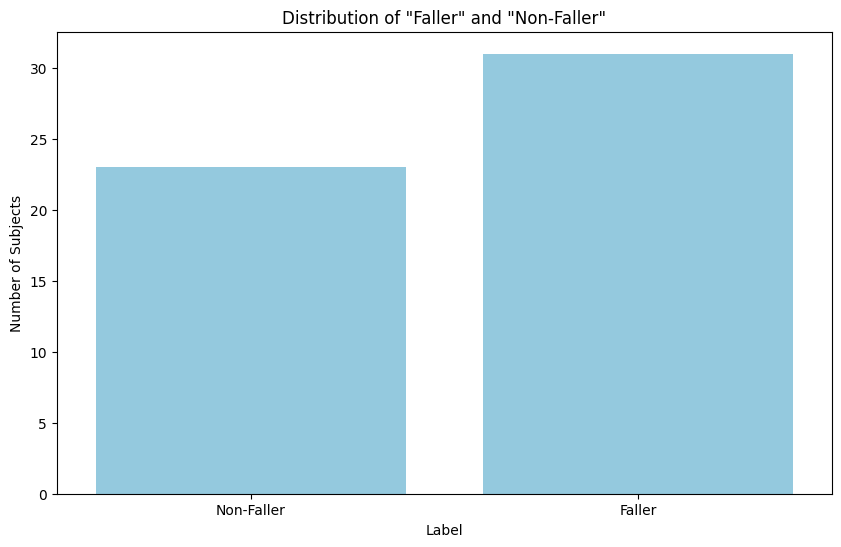

In [19]:
# Explicitly create bins for "Faller" label
faller_bins = [-0.5, 0.5, 1.5]  # 0: Non-Faller, 1: Faller
faller_labels = ['Non-Faller', 'Faller']
metadata_df['FallerGroup'] = pd.cut(metadata_df['Faller'].astype('category').cat.codes, bins=faller_bins, labels=faller_labels, right=False)

# Group by weight group and count the number of unique subjects for each group
subject_counts = metadata_df.groupby('FallerGroup')['Subject'].nunique().reset_index()

# Create separate histograms for "Faller" and "Non-Faller" labels
plt.figure(figsize=(10, 6))
sns.barplot(x='FallerGroup', y='Subject', data=subject_counts, color='skyblue')

# Set labels and title
plt.xlabel('Label')
plt.ylabel('Number of Subjects')
plt.title('Distribution of "Faller" and "Non-Faller"')

# Show the plot
plt.show()

### Pearson Correlation Matrix
Calculates and visualizes the Pearson correlation between all accelerometer and gyroscope axes.

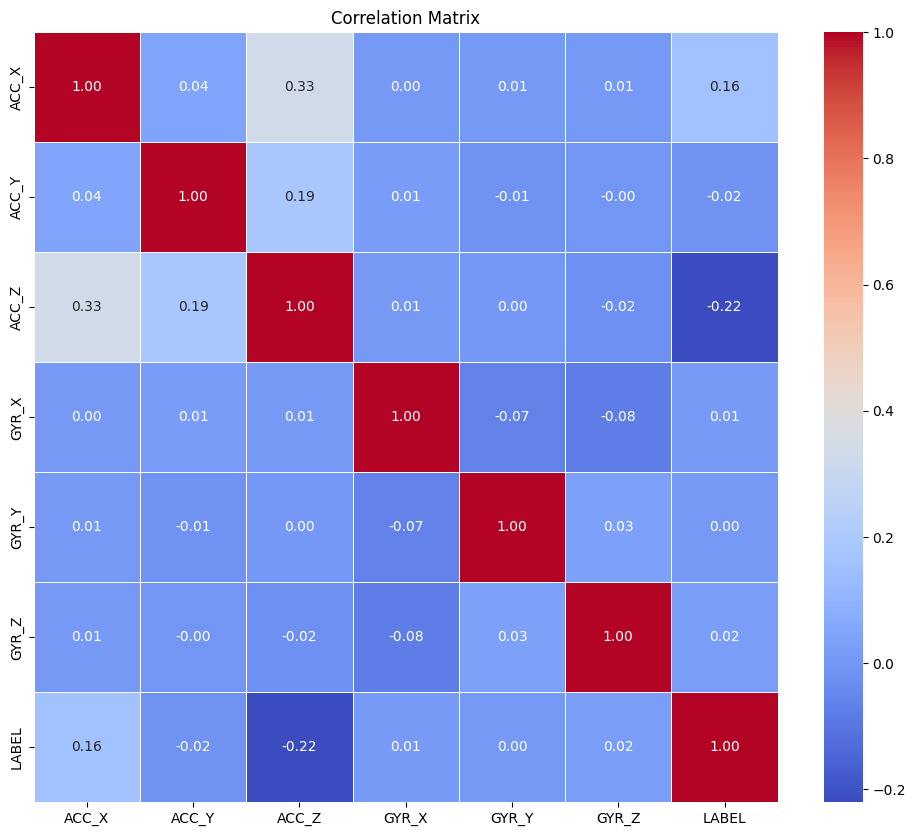

In [20]:
# Calculate correlation matrix
correlation_matrix = sensor_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Set title
plt.title('Correlation Matrix')

# Show the plot
plt.show()

Label Correlation analysis with Scatter Plots - For 8 Classes only

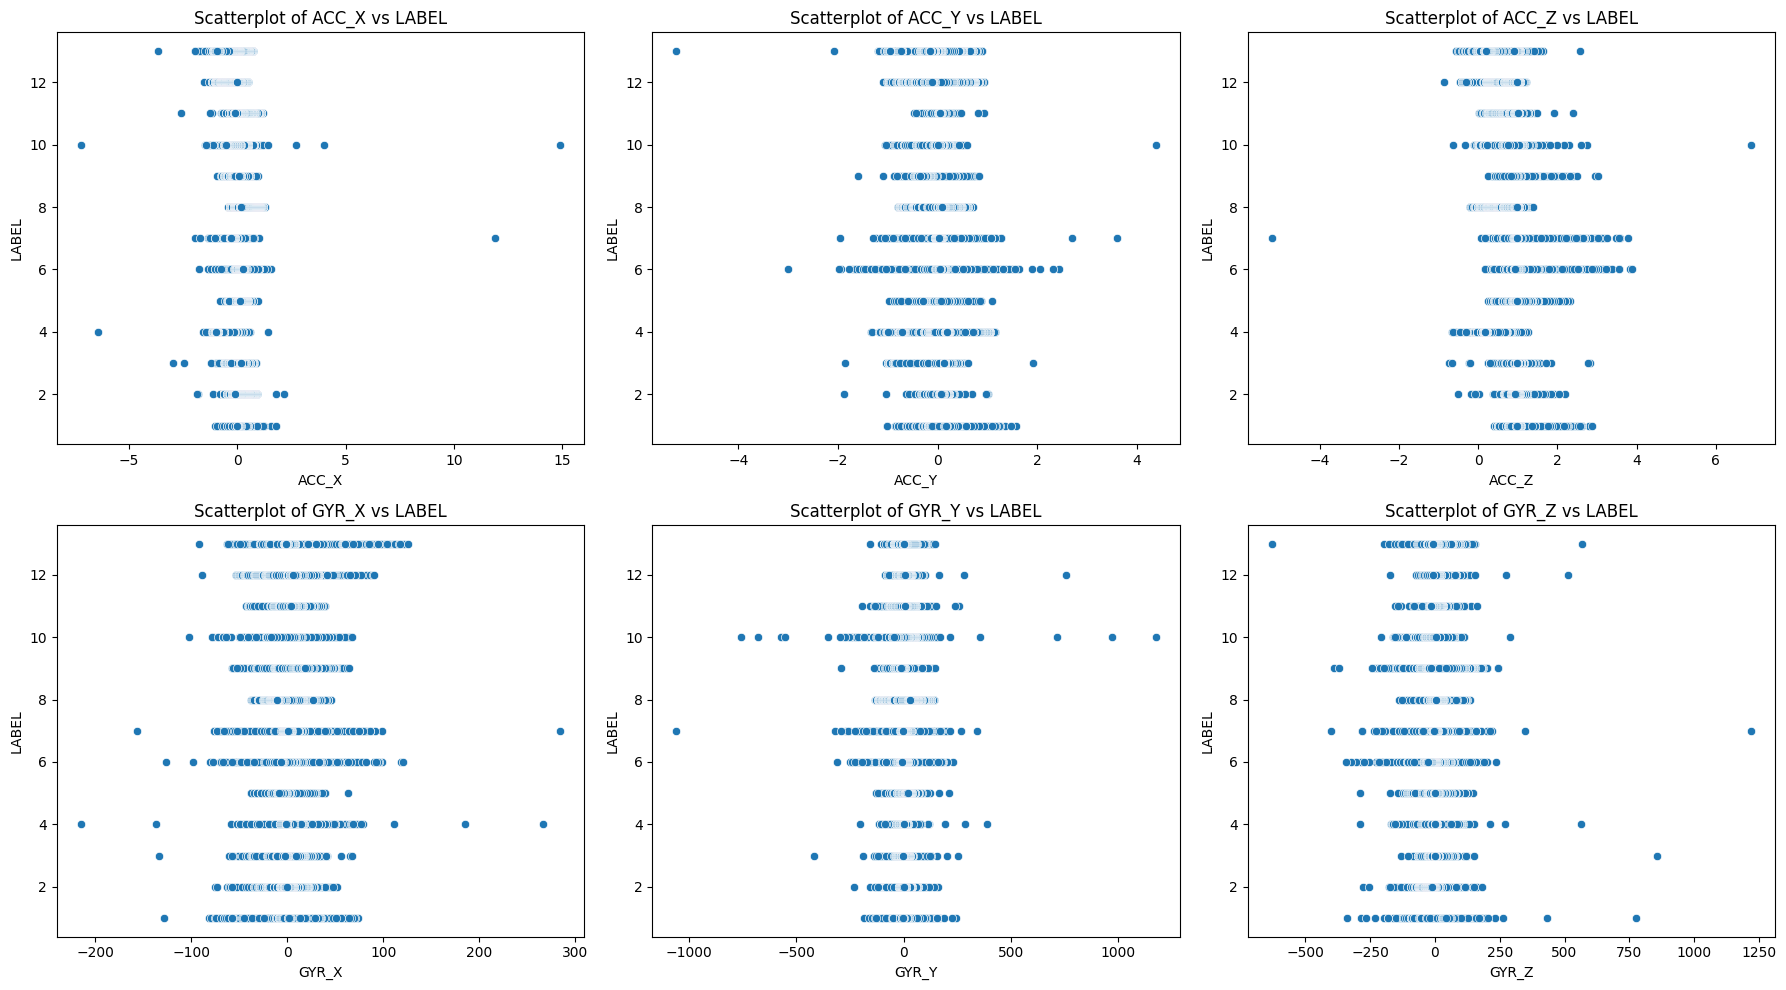

In [21]:
# List of sensor axes
sensor_axes = ['ACC_X', 'ACC_Y', 'ACC_Z', 'GYR_X', 'GYR_Y', 'GYR_Z']

# Set up subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Loop through sensor axes to create subplots
for i, axis in enumerate(sensor_axes):
    sns.scatterplot(x=axis, y='LABEL', data=sensor_data, ax=axes[i])
    axes[i].set_title(f'Scatterplot of {axis} vs LABEL')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### 2 Random Subject Data Visual Comparison
visualize and compare sensor signals from two randomly selected subjects performing a specific activity, using the first 500 samples of that activity from each subject 

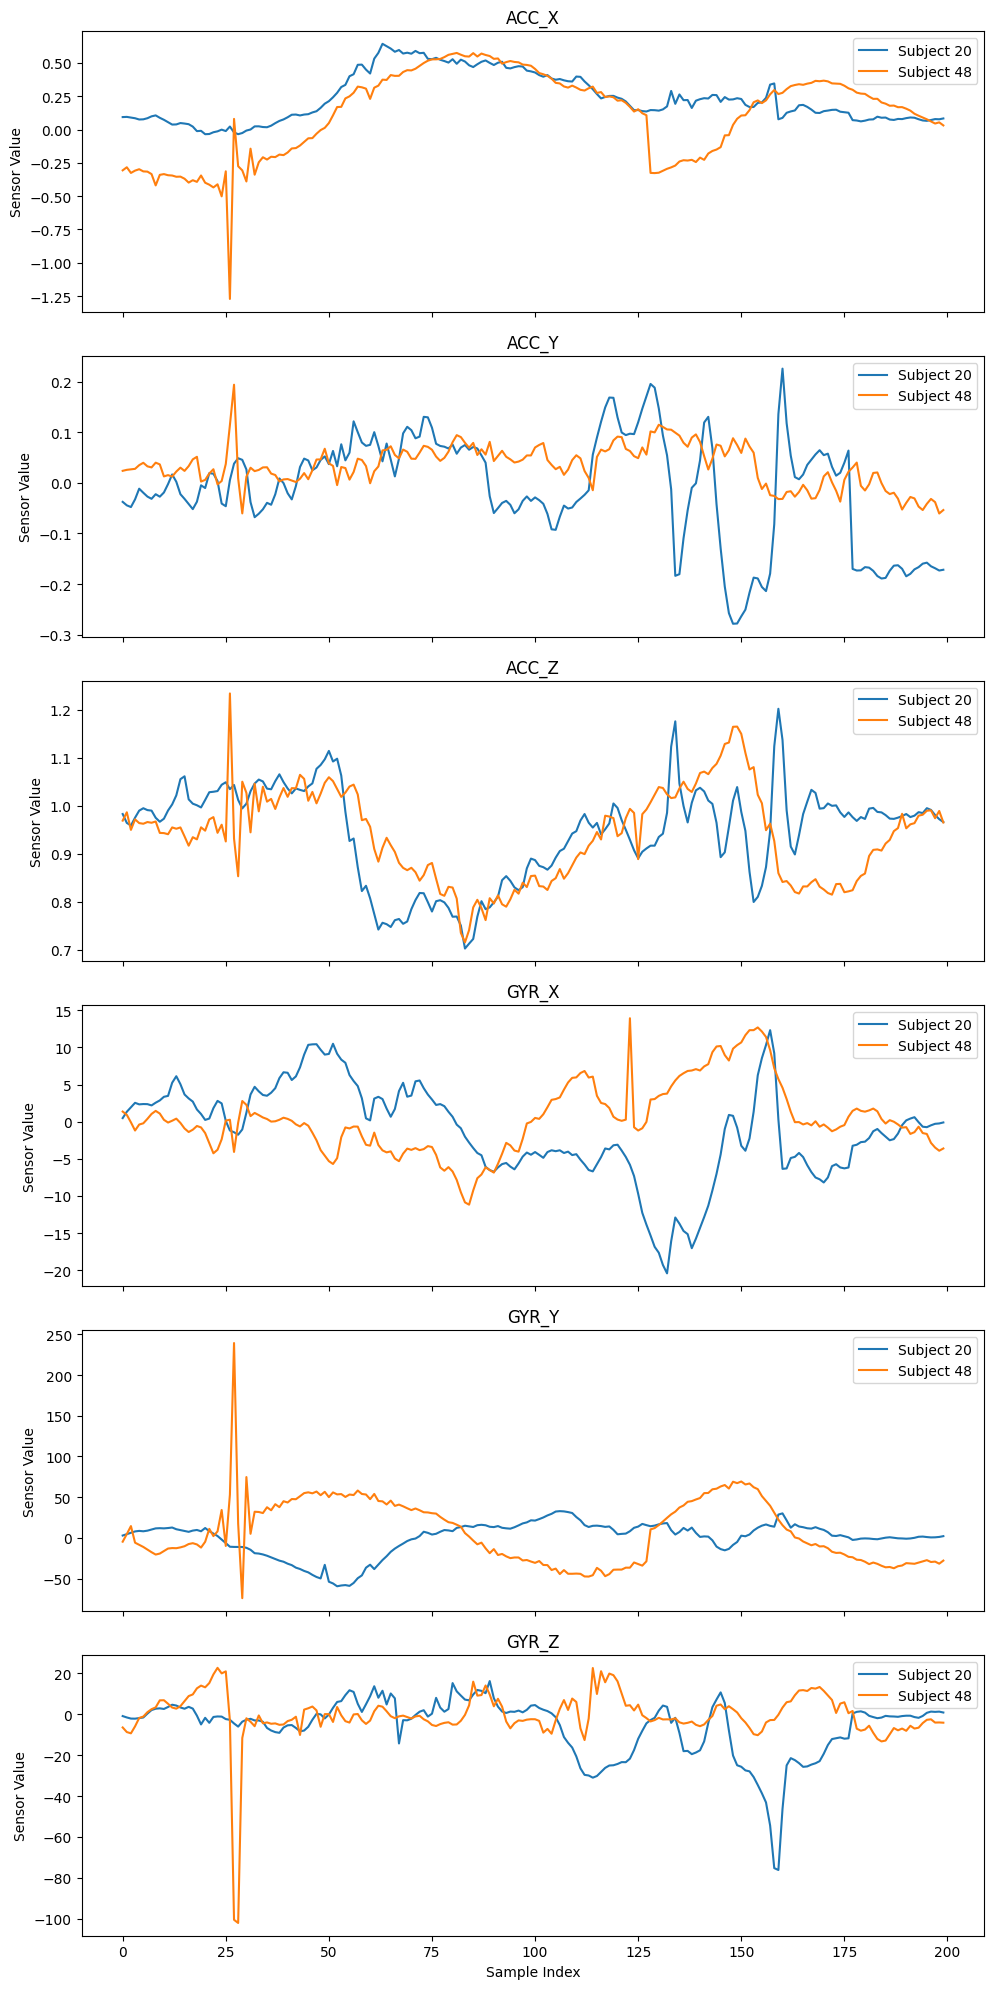

In [44]:
# Get unique subjects from the 'SUBJECT' column
unique_subjects = full_df['Subject'].unique()

# Select 2 random subjects
selected_subjects = np.random.choice(unique_subjects, 2, replace=False)
selected_subjects = [20, 48]  # <-- altera aqui conforme necessário
samples_to_plot = 200
label_to_plot = 11

# Set up subplots
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 20), sharex=True)

# Select the first 1000 samples for each subject
selected_samples = {}
for subject in selected_subjects:
    subject_data = full_df[(full_df['Subject'] == subject) & (full_df['LABEL'] == label_to_plot)].head(samples_to_plot)
    selected_samples[subject] = subject_data

# Plot the data columns on the respective subplots
for i, sensor_axis in enumerate(['ACC_X', 'ACC_Y', 'ACC_Z', 'GYR_X', 'GYR_Y', 'GYR_Z']):
    for subject in selected_subjects:
        axes[i].plot(np.arange(samples_to_plot), selected_samples[subject][sensor_axis], label=f'Subject {subject}')

    # Customize subplot
    axes[i].set_title(f'{sensor_axis}')
    axes[i].set_ylabel('Sensor Value')
    axes[i].legend()

# Customize the overall plot
plt.xlabel('Sample Index')

# Save as SVG
plt.tight_layout()
plt.savefig("sensor_signals_transition.svg", format="svg")

plt.show()

# Data PreProcessing and Subject Split


### 🔧 Butterworth Low-Pass Filter

This function applies a Butterworth low-pass filter to selected sensor axes (e.g., accelerometer and gyroscope data).
It helps remove high-frequency noise while preserving relevant motion signals. 

- `cutoff`: Frequency threshold in Hz.
- `fs`: Sampling rate (default 50 Hz).
- `order`: Filter order (default 4).

In [23]:
from scipy.signal import butter, filtfilt
import numpy as np
import pandas as pd

def butterworth_filter(df, columns, cutoff=20, fs=50, order=4):
    """
    Applies a Butterworth low-pass filter to specified columns in a DataFrame.

    Parameters:
    - df: pd.DataFrame – The input data.
    - columns: list – List of column names to filter (e.g., ['ACC_X', 'ACC_Y', ...]).
    - cutoff: float – Cutoff frequency in Hz.
    - fs: float – Sampling rate in Hz.
    - order: int – Order of the filter.

    Returns:
    - df_filtered: pd.DataFrame – Filtered copy of the input DataFrame.
    """
    df_filtered = df.copy()
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)

    for col in columns:
        df_filtered[col] = filtfilt(b, a, df_filtered[col].values)

    return df_filtered

### Subject-Wise Train/Validation/Test Split

This function splits the dataset into train, validation, and test sets by subject ID (not randomly by row),
ensuring that no data leakage occurs between subjects across splits.

- `train_ratio`: Proportion of subjects in the training set.
- `val_ratio`: Proportion in validation (from remaining).
- `random_state`: Ensures reproducibility.

In [24]:
from sklearn.model_selection import train_test_split

def split_by_subject(df, train_ratio=0.75, val_ratio=0.10, random_state=42):
    """
    Splits a DataFrame by unique subject IDs into train/val/test splits.

    Parameters:
    - df: pd.DataFrame – Input dataset.
    - train_ratio: float – Ratio of subjects to use for training.
    - val_ratio: float – Ratio for validation.
    - random_state: int – Seed for reproducibility.

    Returns:
    - train_df, val_df, test_df – Partitioned DataFrames.
    """
    subjects = df['Subject'].unique()
    train_subs, test_subs = train_test_split(subjects, test_size=(1 - train_ratio), random_state=random_state)
    val_size = val_ratio / (1 - train_ratio)
    val_subs, test_subs = train_test_split(test_subs, test_size=(1 - val_size), random_state=random_state)

    train_df = df[df['Subject'].isin(train_subs)].reset_index(drop=True)
    val_df   = df[df['Subject'].isin(val_subs)].reset_index(drop=True)
    test_df  = df[df['Subject'].isin(test_subs)].reset_index(drop=True)

    return train_df, val_df, test_df


### Compute Normalization Stats & Apply Min-Max or Z-Score Normalization

This function normalizes sensor data using either:
- `minmax`: Scales to [0, 1] using training set min/max.
- `meanstd`: Z-score normalization using training set mean/std.

Applies consistent transformation across train, val, and test sets.

In [25]:
def compute_stats(df, columns):
    """
    Computes min, max, mean, std for given columns.

    Returns:
    - Dictionary with column-wise stats.
    """
    stats = {}
    for col in columns:
        stats[col] = {
            'min': df[col].min(),
            'max': df[col].max(),
            'mean': df[col].mean(),
            'std': df[col].std()
        }
    return stats


def normalize(df, stats, method='minmax'):
    """
    Normalizes sensor columns based on given stats and method.

    Parameters:
    - df: pd.DataFrame – Data to normalize.
    - stats: dict – Precomputed stats.
    - method: 'minmax' or 'meanstd'

    Returns:
    - df_norm: pd.DataFrame – Normalized data.
    """
    df_norm = df.copy()
    for col, vals in stats.items():
        if method == 'minmax':
            df_norm[col] = (df[col] - vals['min']) / (vals['max'] - vals['min'] + 1e-8)
        elif method == 'meanstd':
            df_norm[col] = (df[col] - vals['mean']) / (vals['std'] + 1e-8)
        else:
            raise ValueError("Normalization method must be 'minmax' or 'meanstd'")
    return df_norm


### Example: Filtering, Splitting, and Normalizing the Dataset

Here, we demonstrate the full pipeline:
1. Filter raw signals using a Butterworth filter.
2. Perform subject-based train/val/test split.
3. Compute training statistics.
4. Normalize all splits using training stats.

In [28]:
sensor_cols = ['ACC_X', 'ACC_Y', 'ACC_Z', 'GYR_X', 'GYR_Y', 'GYR_Z']

# Filter
df_filtered = butterworth_filter(merged_df, sensor_cols, cutoff=20)

# Split
train_df, val_df, test_df = split_by_subject(df_filtered)

# Normalize
train_stats = compute_stats(train_df, sensor_cols)
train_df = normalize(train_df, train_stats, method='meanstd')
val_df = normalize(val_df, train_stats, method='meanstd')
test_df = normalize(test_df, train_stats, method='meanstd')


## ✅ Preprocessing Summary

After executing the full EDA and preprocessing pipeline, the HAR dataset is now standardized and ready for modeling. The following steps have been completed:

- All subject-level CSV files have been successfully **loaded and merged**.
- **Class distributions** have been visualized and stored for reporting purposes.
- A configurable **Butterworth filter** has been applied to smooth sensor signals and reduce high-frequency noise.
- **Data normalization** (Min-Max or Z-Score) was applied using only the training set statistics to prevent data leakage.
- The dataset has been split into **training, validation, and test sets** using a subject-wise strategy to ensure independence between subsets.

These steps ensure that the dataset is clean, consistent, and aligned with best practices for training robust and generalizable activity recognition models.
